
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `CHAN JIE HO`

**Student ID(s):**     `961948`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

In [2]:
# Preprocess function to prepare the data by reading it from a file and converting it into a useful format 
# for training and testing

def preprocess(filestream, numeric, class_index, ID_index, test_size, discretise=False):
    X = []
    y = []
    
    # Start by reading the file and storing it appropriately
    with open(filestream, mode='r') as fin:
        for line in fin:
            if line != "":
                atts = line.strip().split(",")
                
                # Separate the label column
                label = atts.pop(class_index)
                y.append(label)
                
                # Get rid of index
                if ID_index != None:
                    atts.pop(ID_index)

                # Check if the dataset is supposed to be numeric or mixed
                if numeric == None:
                    X.append(atts) 

                # If yes, then we have to convert it to float types
                else: 
                    X_numeric = []         
                    
                    # In the case that the whole dataset is numeric 
                    if numeric == "Numeric":
                        for i in range(len(atts)):
                            X_numeric.append(float(atts[i]))
                            
                    # In the case that dataset has a mix of attribute types
                    else:
                        for i in range(len(numeric)):
                            if numeric[i] == 2:
                                X_numeric.append(float(atts[i]))
                            else:
                                X_numeric.append(atts[i])
                    X.append(X_numeric)
    
    # I chose to split the training so that we do not overfit the model and so that the test will be unseen
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Fill in missing values for the training set with the mode () – I chose mode because I acknowledged that
    # all the missing values are not of the numeric type
    X_mode = pd.DataFrame(X_train).mode().values[0]
    
    for line in X_train:
         for index in range(len(line)):
            if line[index] == '?':
                line[index] = X_mode[index]
                
    # In the case we want to discretise the numeric columns, we can use the equal width binning method
    X_train = pd.DataFrame(X_train)
    if discretise:
        if numeric == "Numeric":
            for index in X_train:
                X_train[index] = pd.cut(X_train[index], 3)
        else:
            for index in X_train:
                if numeric[index] == 2:
                    X_train[index] = pd.cut(X_train[index], 3)
                    
    return pd.DataFrame(X_train), pd.DataFrame(X_test), pd.DataFrame(y_train), pd.DataFrame(y_test)
    

In [3]:
# Get_instances function to get the number of instances with that class label

def get_instances(array, prior):
    n_instances = 0
    
    for line in array:
        n_instances += 1
        prior[line] += 1

    return n_instances

In [4]:
# Get_likelihoods function to get the likelihood of the attribute being that value given a class

def get_likelihoods(X, y, likelihoods, class_instances):
    for index in range(len(X)):
        likelihoods[y[index]][X[index]] += 1
    for lbl in likelihoods.keys():
            for value in likelihoods[lbl].keys():
                likelihoods[lbl][value] = likelihoods[lbl][value]/class_instances[lbl]
    return likelihoods

In [5]:
# Get_numeric_likelihoods function to get the mu and sigma of the instances of that class to use in the Gaussian pdf

def get_numeric_likelihoods(X, y, likelihoods, class_instances):
    for lbl in class_instances.keys():
        values = []
        for index in range(len(X)):
            if y[index] == lbl:
                values.append(X[index])
        
        mu = np.mean(values)
        sigma = np.std(values)
        likelihoods[lbl]["mu"] = mu
        likelihoods[lbl]["sigma"] = sigma
        
    return likelihoods



In [6]:
# Train function to calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(X_train, y_train, numeric, discretise=False):
    
    # Store all the class instances 
    class_instances = defaultdict(float)
    total_instances = get_instances(y_train.iloc[:,0],class_instances)
    
    # All the likelihoods will be stored as an array of default dictionaries of default dictionaries, with each index
    # corresponding to the attribute number
    all_likelihoods = []
    
    # Iterate through each attribute to get all the likelihoods
    for attr in range(X_train.shape[1]):
        
        # Create the default dictionary of default dictionaries to store all the probabilities
        likelihoods = defaultdict(lambda: defaultdict(float))
        
        # If it's not numeric, then just calculate it normally
        if numeric == None:
            likelihoods = get_likelihoods(X_train.iloc[:,attr], y_train[0], likelihoods, class_instances)
            
        else:
            # In the case that we have decided to discretise, it's similar to being nominal or ordinal
            if discretise == True:
                likelihoods = get_likelihoods(X_train.iloc[:,attr], y_train[0], likelihoods, class_instances)
            else:
                # If it's numeric then we must appropriately get the mu and sigmas
                if numeric == "Numeric":
                    likelihoods = get_numeric_likelihoods(X_train.iloc[:,attr],y_train[0],likelihoods, class_instances)
                else:
                    if numeric[attr] == 2:
                        likelihoods = get_numeric_likelihoods(X_train.iloc[:,attr],y_train[0],likelihoods, class_instances)
                    else:
                        likelihoods = get_likelihoods(X_train.iloc[:,attr], y_train[0], likelihoods, class_instances)

        all_likelihoods.append(likelihoods)
    
    # Store the priors of the class labels
    class_prior = defaultdict(float)
    
    for lbl in class_instances.keys():
        class_prior[lbl] = class_instances[lbl]/total_instances
    
    return class_prior, all_likelihoods, class_instances

In [7]:
# Gaussian_pdf function to calculate probability based on Gaussian distribution
def Gaussian_pdf(x, mu, sigma):    
    return (1/(sigma*np.sqrt(2*np.pi)))*(np.exp((-0.5*((x-mu)/sigma)**2)))

In [8]:
# Predict function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

def predict(X_test, class_prior, all_likelihoods, numeric, discretise = False):
    
    # In the case that a value was not seen in training
    epsilon = 0.0000000000000001 
    predictions = []
    k = 0
    
    # Iterate through every row and each attribute
    for index, rows in X_test.iterrows():
        probabilities = defaultdict(float)
        
        # For each possible class, find the probability of it being that class
        # I used log transformation because they are very small values
        for lbl in class_prior.keys():
            
            # First add the prior of it even being that class
            prob = np.log(class_prior[lbl])
            
            # If it's not numeric then just take the probability that we already found
            if numeric == None:    
                # prob = log(p(lbl)) + log(p(attr|lbl)) + ...
                for i in range(X_test.shape[1]):
                    prob += np.log(max(epsilon, all_likelihoods[i][lbl][rows[i]]))
                    
            else:
                if discretise:
                    
                    # If we had discretised, find the probability of the corresponding bin
                    if numeric == "Numeric":
                        for i in range(X_test.shape[1]):
                            p = 0
                            for interval in all_likelihoods[i][lbl]:
                                
                                if rows[i] in interval:
                                    p = all_likelihoods[i][lbl][interval]
                            prob += np.log(max(epsilon, p))
                    else:
                        for i in range(X_test.shape[1]):
                            if numeric[i] == 2:
                                for interval in all_likelihoods[i][lbl]:
                                    if rows[i] in interval:
                                        p = all_likelihoods[i][lbl][interval]
                            else:
                                p = all_likelihoods[i][lbl][rows[i]]
                            prob += np.log(max(epsilon, p))
                    
                else:
                    
                    # If it's not discretised, then we must find the probability using the Gaussian pdf using the mu
                    # and sigma
                    if numeric == "Numeric":
                        for i in range(X_test.shape[1]):
                            mu = all_likelihoods[i][lbl]['mu']
                            sigma = all_likelihoods[i][lbl]['sigma']
                            x = rows[i]
                            prob += np.log(Gaussian_pdf(x,mu,sigma))
                    else:
                        for i in range(X_test.shape[1]):    
                            if numeric[i] == 2:
                                mu = all_likelihoods[i][lbl]['mu']
                                sigma = all_likelihoods[i][lbl]['sigma']
                                x = rows[i]
                                prob += np.log(Gaussian_pdf(x,mu,sigma))
                            else: 
                                for i in range(X_test.shape[1]):
                                    prob += np.log(max(epsilon, all_likelihoods[i][lbl][rows[i]]))
           
            # Store all the probability of it being that class
            probabilities[lbl] = prob
            
        # Get the class with the highest probability
        max_key = max(probabilities, key=probabilities.get)
        predictions.append(max_key)
        k+=1
        
    return predictions

In [9]:
# Classification_results to find all the TP, FP, FN, AND TN values

def classification_results(predictions, ground, class_instances):

    result = defaultdict(list)

    for lbl in class_instances.keys():
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for row in range(len(predictions)):
            if predictions[row] == lbl:
                if ground[row] == lbl:
                    TP += 1
                else:
                    FP += 1
            else:
                if ground[row] == lbl:
                    FN += 1
                else:
                    TN += 1
        result[lbl]=[TP,FP,TN,FN]
    return result

In [10]:
# Evaluation_metrics to find calculate the evaluation metrics like accuracy, recall, etc.

def evaluation_metrics(result, class_instances):
    accuracy = 0
    precision = 0
    recall = 0
    specificity = 0

    for label in class_instances.keys():
        lbl = result[label]
        accuracy += lbl[0]

        if lbl[0] != 0:
            weight = (class_instances[label]/sum(class_instances.values()))
            precision += weight*(lbl[0]/(lbl[0]+lbl[1]))
            recall += weight*(lbl[0]/(lbl[0]+lbl[3]))
            specificity += weight*(lbl[2]/(lbl[2]+lbl[1]))

        else:
            precision += 0
            recall += 0
            specificity += 0

    classes = len(class_instances.keys())
    F_score = (2*precision*recall)/(precision+recall)
    
    return accuracy, precision, recall, F_score, specificity

In [11]:
# Evaluate function to evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(predictions, y_test):
    ground = y_test[0].values.tolist()
    result = classification_results(predictions, ground, class_instances)
    accuracy, precision, recall, F_score, specificity = evaluation_metrics(result, class_instances)
    accuracy = accuracy/len(predictions)
    error_rate = 1 - accuracy
    

    return accuracy, error_rate, precision, recall, F_score, specificity

In [12]:
# Baseline function to use the 0R baseline method to choose the most common class
def baseline(y_test, class_instances):
    prediction = []
    for i in range(len(y_test)):
        prediction.append(max(class_instances, key=class_instances.get))
    return prediction

In [13]:
# Print_results function to print (obviously...)
def print_results(accuracy, error_rate, precision, recall, F_score, specificity):
    print("Average Accuracy = {}".format(accuracy))
    print("Average Error rate = {}".format(error_rate))
    print("Average Precision = {}".format(precision))
    print("Average Recall = {}".format(recall))
    print("Average F-score = {}".format(F_score))
    print("Average Specificity = {}".format(specificity))

In [18]:
iterations = 5
average_accuracy = []
average_error_rate = []
average_precision = []
average_recall = []
average_F_score = []
average_specificity = []

for i in range(iterations):
    data = "car.data"
    numeric = None
    discretise = False
    X_train, X_test, y_train, y_test = preprocess(data,numeric, 6, None, 0.3, discretise)
    class_prior, all_likelihoods, class_instances = train(X_train, y_train, numeric, discretise)
    predictions = predict(X_test, class_prior, all_likelihoods, numeric, discretise)
    accuracy, error_rate, precision, recall, F_score, specificity = evaluate(predictions, y_test)
    average_accuracy.append(accuracy)
    average_error_rate.append(error_rate)
    average_precision.append(precision)
    average_recall.append(recall)
    average_F_score.append(F_score)
    average_specificity.append(specificity)

    
print_results(np.mean(average_accuracy), np.mean(average_error_rate), np.mean(average_precision), np.mean(average_recall), np.mean(average_F_score), np.mean(average_specificity))


Average Accuracy = 0.846242774566474
Average Error rate = 0.15375722543352602
Average Precision = 0.8415806782842846
Average Recall = 0.8483768187456023
Average F-score = 0.8449475301616864
Average Specificity = 0.831677566093562


## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develop codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

In [26]:
error_rate_reduction = 0
iterations = 10
for i in range(iterations):
    data = "wdbc.data"
    numeric = "Numeric"
    discretise = False
    X_train, X_test, y_train, y_test = preprocess(data,numeric, 1, 0, 0.3, discretise)
    class_prior, all_likelihoods, class_instances = train(X_train, y_train, numeric, discretise)
    predictions = predict(X_test, class_prior, all_likelihoods, numeric, discretise)
    result = evaluate(predictions, y_test)
    
    discretise = True
    discrete_X_train, discrete_X_test, discrete_y_train, discrete_y_test = preprocess(data,numeric, 1, 0, 0.3, discretise)
    discrete_class_prior, discrete_all_likelihoods, discrete_class_instances = train(discrete_X_train, discrete_y_train, numeric, discretise)
    discrete_predictions = predict(discrete_X_test, discrete_class_prior, discrete_all_likelihoods, numeric, discretise)
    discrete_result = evaluate(discrete_predictions, discrete_y_test)

    error_rate_reduction += ((result[1]-discrete_result[1])/result[1])*100

print("Average error rate reduction = {}%".format(error_rate_reduction/iterations))

/Users/hochanjie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


Average error rate reduction = -15.47863247863246%


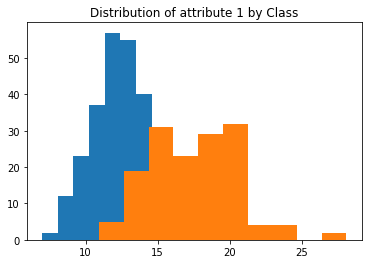

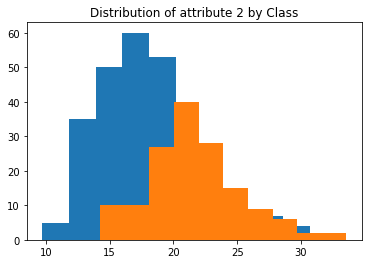

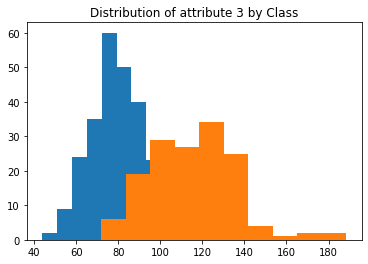

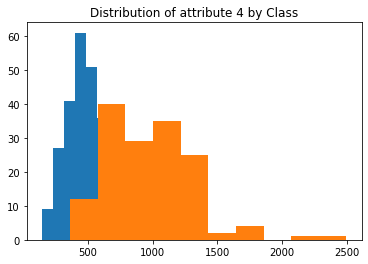

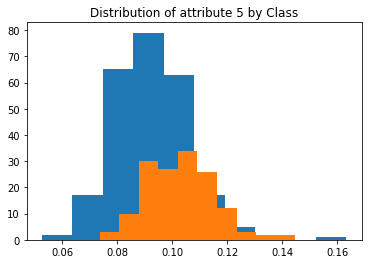

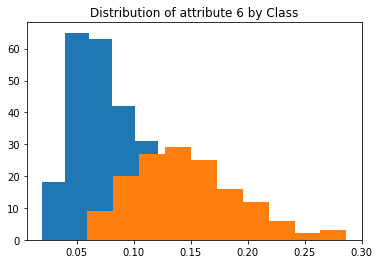

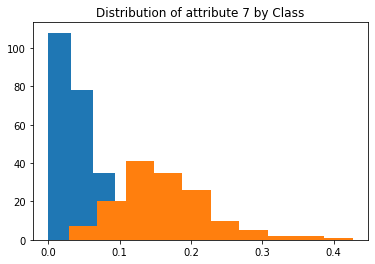

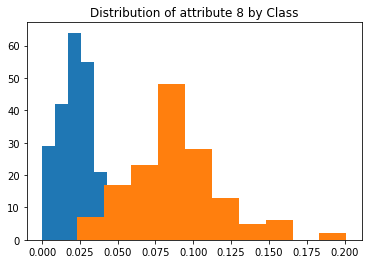

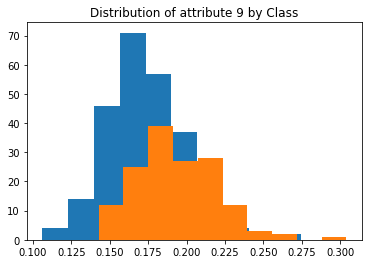

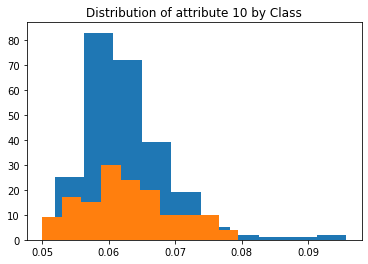

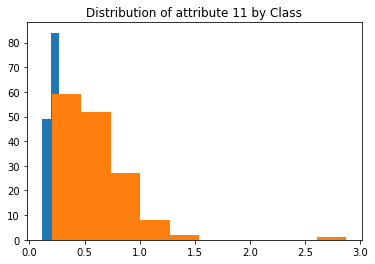

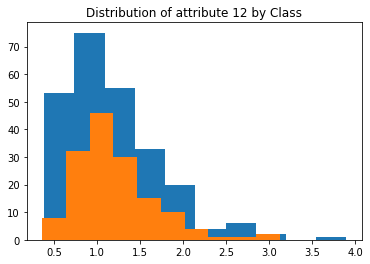

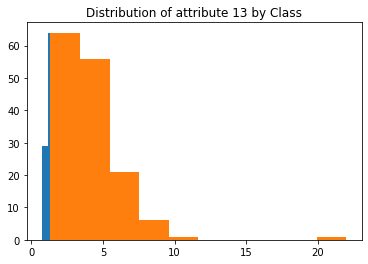

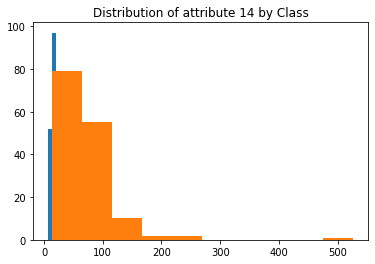

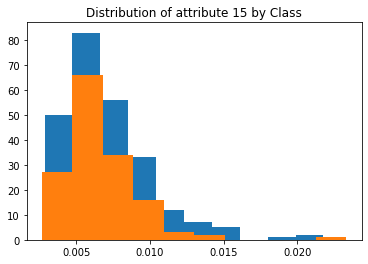

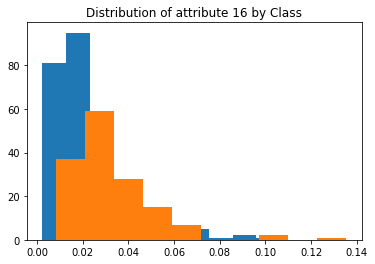

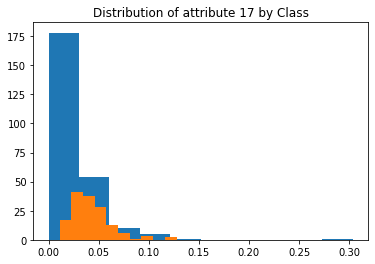

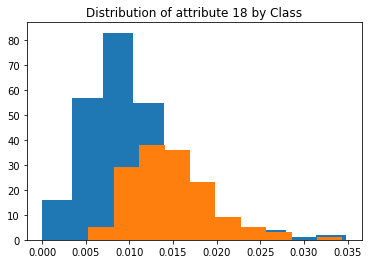

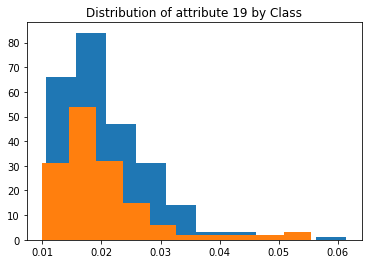

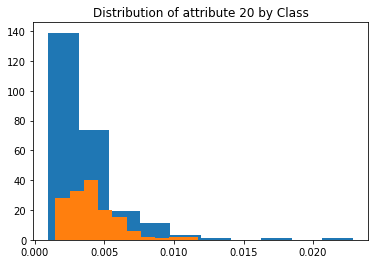

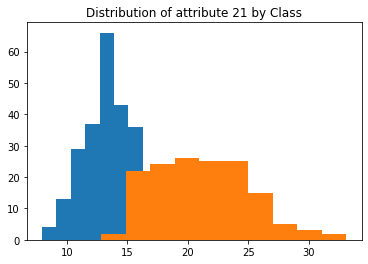

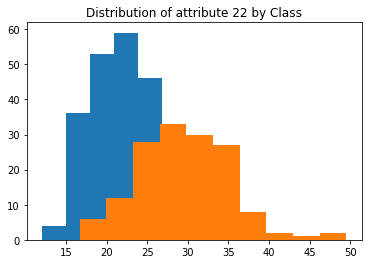

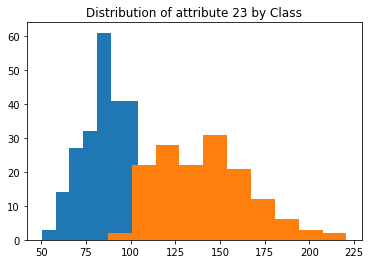

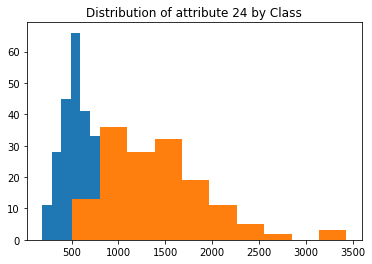

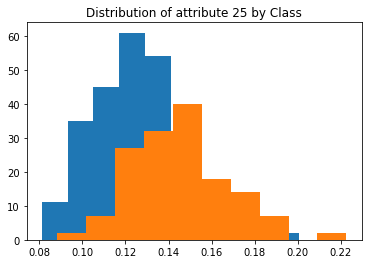

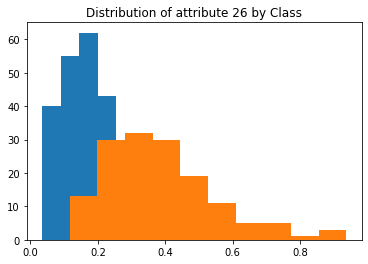

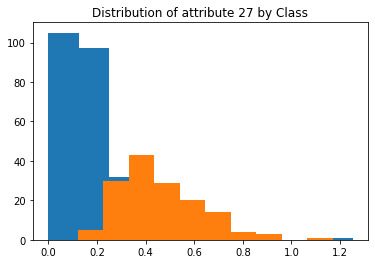

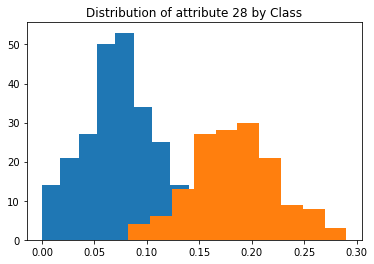

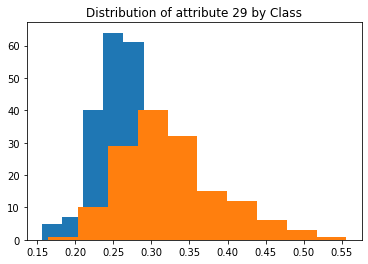

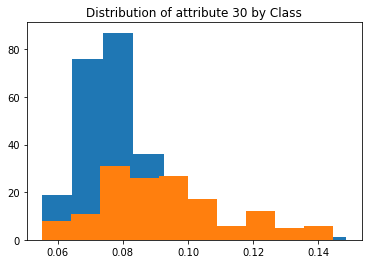

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(X_train.shape[1]):
    column = X_train.iloc[:,i]
    classes = class_prior.keys()
    plt.title("Distribution of attribute {} by Class".format(i+1))
    for label in classes:
        values = []
        for row in range(len(column)):
            
            if y_train[0][row] == label:
                values.append(column[row])
        plt.hist(np.array(values))
    plt.show()

As shown in the negative average error reduction rate, the discretization method does slightly worse as compared to the Gaussian Naïve Bayes model, however this is a very small reduction. One reason that the Gaussian model performed better is likely because the underlying data is already normally distributed, or has a Gaussian distribution. The Gaussian model takes these distributions into consideration and is also less susceptible to outliers as compared to the discretization method. This is further emphasised due to the fact that I used the equal width binning method. Had I used a k-means clustering method to perform the binning, the discretization method may have very likely performed even better than the Gaussian method. 

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

In [24]:
error_rate_reduction = 0
iterations = 10
for i in range(iterations):
    data = "breast-cancer-wisconsin.data"
    numeric = None
    discretise = False
    X_train, X_test, y_train, y_test = preprocess(data,numeric, 10, 0, 0.3, discretise)
    class_prior, all_likelihoods, class_instances = train(X_train, y_train, numeric, discretise)
    predictions = predict(X_test, class_prior, all_likelihoods, numeric, discretise)
    result = evaluate(predictions, y_test)
    
    baseline_prediction = baseline(y_test, class_instances)
    baseline_result = evaluate(baseline_prediction, y_test)
    error_rate_reduction = (result[1]-baseline_result[1])/result[1]
    error_rate_reduction += ((result[1]-discrete_result[1])/result[1])*100

print("Average error rate reduction = {}%".format(error_rate_reduction/iterations))

Average error rate reduction = -13.647953216374281%


In [28]:
class_instances

defaultdict(float, {'B': 249.0, 'M': 149.0})

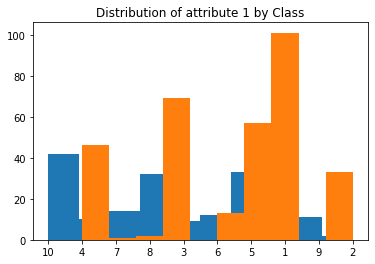

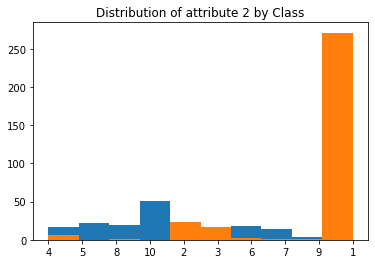

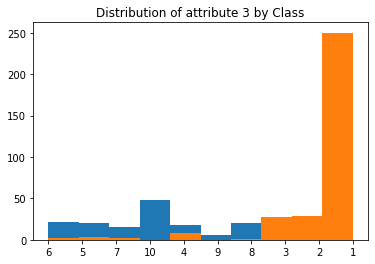

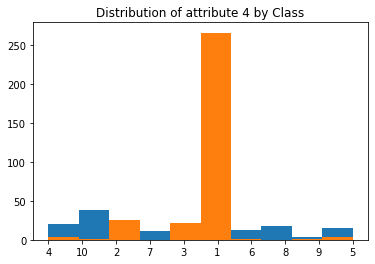

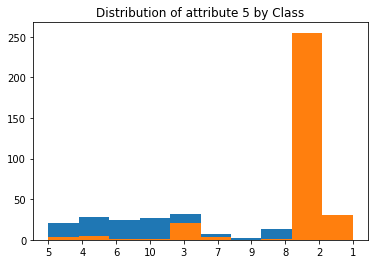

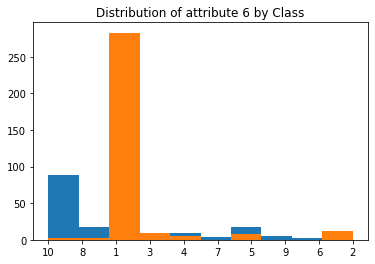

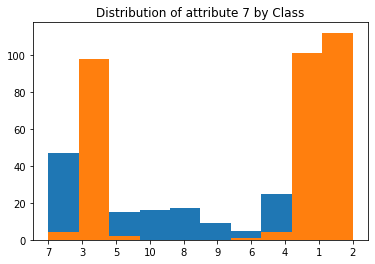

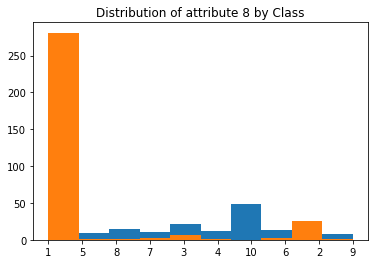

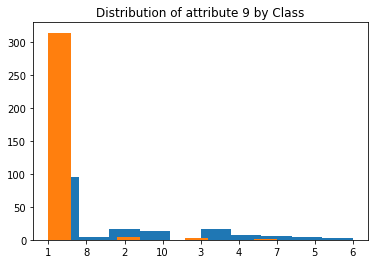

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(X_train.shape[1]):
    column = X_train.iloc[:,i]
    classes = class_prior.keys()
    plt.title("Distribution of attribute {} by Class".format(i+1))
    for label in classes:
        values = []
        for row in range(len(column)):
            
            if y_train[0][row] == label:
                values.append(column[row])
        plt.hist(np.array(values))
    plt.show()

The baseline model that I had chosen was the 0R model and this generally performed a lot worse on the datasets, however, some datasets did not see a significant reduction in the error rate and may even see a positive reduction in the error rate. One pattern I noticed was that it tended to perform worse on the nominal datasets. This is mainly due to the fact that the distribution of the classes is not equal. Going further by plotting out the dataset, we can see that many of the dataset, such as the above, are not actually normally distributed and one can see a much higher frequency in some attribute values (not sorted because they are nominal and sorted would be inappropriate) and this would imply that the class and the attributes have a significant relationship that is being overlooked when we do not consider the attributes.